# 4.Build Model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, RobustScaler

## 4.1 Prepare data

### 4.1.1 Read data and create a column `Year` to help increase a feature for training model.

add a column `Year` - distance from First Registration's Year of the car to now.

In [2]:

data = pd.read_csv("data\cleaned_data_edited.csv",index_col="ID")

# chuyển Field "Date" thành kiểu datetime
data["First registration"] = pd.to_datetime(data["First registration"])
data["Year"] = 2023 - data["First registration"].dt.year 
data.drop(columns=["First registration"],inplace=True)

C:\Users\dntti\AppData\Local\Temp\ipykernel_2872\431993601.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data["First registration"] = pd.to_datetime(data["First registration"])


### 4.1.2 Find object columns and low cardinality columns

Due to our data have many categorical columns, we have to do one hot encoding for training model. Before handling one-hot, we have to:
- Find categorical (object) columns.
- Find columns that have low cardinality.

Why have to find columns that have low cardinality?
- For large datasets with many rows, one-hot encoding can greatly expand the size of the dataset.  For this reason, we typically will only one-hot encode columns with relatively low cardinality.  Then, high cardinality columns can either be dropped from the dataset, or we can use ordinal encoding.

In [3]:
s = (data.dtypes == 'object')
object_cols = list(s[s].index)
print("Categorical variables:")
print(object_cols)

low_cardinality_cols = [col for col in object_cols if data[col].nunique() < 10]
# low_cardinality_cols.append("Make")
print("Low cardinality col:")
print (low_cardinality_cols)

Categorical variables:
['CARNAME', 'Make', 'Model', 'Body color', 'Interior color', 'Interior material', 'Body', 'Doors', 'Fuel', 'Transmission', 'Drive type', 'Emission class', 'Condition', 'Tags']
Low cardinality col:
['Interior color', 'Interior material', 'Doors', 'Fuel', 'Transmission', 'Drive type', 'Emission class', 'Condition']


### 4.1.3 Find tags


- Due to the column `Tags` is a multiple value column, we have to choose which tag (special function) to do one hot encoding and put to the model 

In [4]:

one_hot_tags =  data[["Price(EUR)","Tags"]].copy()
# scaler = RobustScaler()
# # Fit và transform dữ liệu
# one_hot_tags['Price(EUR)'] = scaler.fit_transform(one_hot_tags[['Price(EUR)']]) 

# Get each tag in each multiple value row
tags = one_hot_tags['Tags'].str.split('; ', expand=True)

# Stack to make the DataFrame long, then get_dummies and group by index before summing
get_dummy = pd.get_dummies(tags.stack()).groupby(level=0).sum()

# Join the one-hot encoded DataFrame back to the original DataFrame
one_hot_tags = one_hot_tags.join(get_dummy)

# Drop the `Tags` because we dont need it anymore
one_hot_tags = one_hot_tags.drop("Tags",axis=1)

# Calculate correlation with 'Price(EUR)'
correlation = one_hot_tags.corr()['Price(EUR)']

# Get the top 10 tags with highest correlation with 'Price(EUR)'
top_10_corr_tags = correlation.nlargest(9).index

# Select only the top 10 tags with highest correlation with 'Price(EUR)'
one_hot_tags = one_hot_tags[top_10_corr_tags].drop(["Price(EUR)"],axis=1)

one_hot_tags.columns


Index(['Air suspension', 'Ventilated front seats',
       'Electric adjustable front seats', 'Digital cockpit', 'Burmester audio',
       'Heated rear seats', 'Laser headlights', 'Adaptive cruise control'],
      dtype='object')

### 4.1.4 Find top Car Manufacturers that have high correlation rate with Price

In [5]:
one_hot_Make = pd.get_dummies(data['Make'])
data_encoded = data[['Price(EUR)']].join(one_hot_Make)


correlation = data_encoded.corr()['Price(EUR)']

#LẤy ra top 8 make có tương quan cao nhất > 0.25
top_10_Make = correlation[correlation >= 0.25].index
top_10_Make = top_10_Make.drop("Price(EUR)")

one_hot_Make = one_hot_Make[top_10_Make]
one_hot_Make['Others'] = (one_hot_Make.sum(axis=1) == 0)
one_hot_Make.columns


Index(['Ferrari', 'Lamborghini', 'Rolls-Royce', 'Others'], dtype='object')

## 4.2 Split data

- To train and test a model:
    - First we will split our data into X_train, X_valid, y_train, y_valid dataset.
    - Second, we have to handle categorical features - one hot encoding.

In [6]:
numerical_cols = [cname for cname in data.columns if 
                data[cname].dtype in ['int64', 'float64', 'int32']]

# Keep selected columns only
my_cols = low_cardinality_cols + numerical_cols

X = data[my_cols].copy().reset_index(drop=True)
one_hot_tags = one_hot_tags.reset_index(drop=True)
one_hot_Make = one_hot_Make.reset_index(drop=True)

X = pd.concat([X, one_hot_tags, one_hot_Make], axis=1)

y = X["Price(EUR)"].copy()

X.drop(["Price(EUR)"], axis=1, inplace=True)

X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                      train_size=0.8, test_size=0.2,
                                                      random_state=0)
print(X_train.shape)
print(X_train.columns)


(1831, 28)
Index(['Interior color', 'Interior material', 'Doors', 'Fuel', 'Transmission',
       'Drive type', 'Emission class', 'Condition', 'Seats', 'Power(kW)',
       'CO2 emissions(g/km)', 'Mileage(km)',
       'Consumption(l/100km or kWh/100km)', 'Engine capacity(ccm)',
       'Previous owners', 'Year', 'Air suspension', 'Ventilated front seats',
       'Electric adjustable front seats', 'Digital cockpit', 'Burmester audio',
       'Heated rear seats', 'Laser headlights', 'Adaptive cruise control',
       'Ferrari', 'Lamborghini', 'Rolls-Royce', 'Others'],
      dtype='object')


## 4.3 Create a PipeLine for Cross Validation

### First, we have to define transformer for the Pipeline

Transformer:
- Preprocess Categorical columns.
- Handle outliers in numerical columns.

In [7]:


# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('robustscaler', RobustScaler(with_centering=False)),
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Exclude 'Price(EUR)' from numerical_cols
numerical_cols_to_transform = [col for col in numerical_cols if col != 'Price(EUR)']

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols_to_transform),
        ('cat', categorical_transformer, low_cardinality_cols)
    ])

### Second: Fit model and Predict

In [8]:


my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', RandomForestRegressor(n_estimators=200))
                             ])

my_pipeline.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = my_pipeline.predict(X_valid)

# Evaluate the model
score = mean_absolute_error(y_valid, preds)
print('MAE:', score)

MAE: 5589.543458117776


## 4.4 Cross Validation & Adjust Parameter


--------50 estimators--------
MAE: 6099.5350277887355
--------100 estimators--------
MAE: 6093.185238695104
--------150 estimators--------
MAE: 6067.298740673092
--------200 estimators--------
MAE: 6052.464151517697
--------250 estimators--------
MAE: 6033.367302521241
--------300 estimators--------
MAE: 6026.413656586554


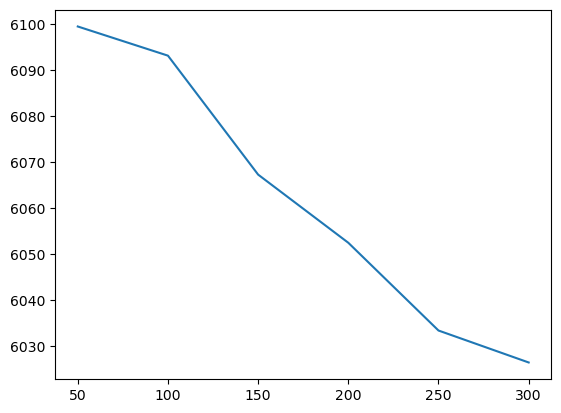

In [9]:
from sklearn.model_selection import cross_val_score
def get_score(n_estimate):
    my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', RandomForestRegressor(n_estimators = n_estimate,
                                                              random_state=0))
                             ])
    scores = -1 * cross_val_score(my_pipeline, X, y ,
                                    cv=5,
                                    scoring='neg_mean_absolute_error')
    return scores.mean()


results = {}
for i in range(1,7):
    print(f'--------{50*i} estimators--------')
    mae = get_score(50*i)
    print(f'MAE: {mae}')
    results[50*i] = mae

%matplotlib inline

plt.plot(list(results.keys()), list(results.values()))
plt.show()

- As we can see, with **n_estimators** = 200, our random forest model seems result the most optimal MAE.

## 4.5 Train model, Test and make Prediction from User Input

In [10]:

def input_car_info():
    # Initialize an empty dictionary to hold user input
    car_info = {}

    # List all the features
    features = ['Interior color', 'Interior material', 'Doors', 'Fuel', 'Transmission', 
                'Drive type', 'Emission class', 'Condition', 'Seats', 'Power(kW)', 
                'CO2 emissions(g/km)', 'Mileage(km)', 'Consumption(l/100km or kWh/100km)', 
                'Engine capacity(ccm)', 'Previous owners', 'Air suspension', 
                'Ventilated front seats', 'Electric adjustable front seats', 
                'Digital cockpit', 'Burmester audio', 'Heated rear seats', 
                'Laser headlights', 'Adaptive cruise control']

    # Ask the user to input values for each feature
    for feature in features:
        value = input(f"Please enter the {feature} of the car: ")
        car_info[feature] = [value]  # Use a list here because pd.DataFrame expects a list

    # Convert the dictionary to a DataFrame
    X_input = pd.DataFrame(car_info)

    return X_input

# Call the function to get user input and create X_input
# X_input = input_car_info()
# X_input


In [11]:
# preds = my_pipeline.predict(X_input)
# preds


In [12]:
# Save model for deploy 
import joblib
joblib.dump(my_pipeline, 'deploy/model.pkl')
print("Model dumped!")

Model dumped!
